# Variational Autoencoders (VAE)

A Variational Autoencoder (VAE) is a type of generative model that learns to generate new data samples similar to those in the training dataset. It is a type of neural network architecture that combines principles from both autoencoders and variational inference.

## How does a VAE work?

### 1. Autoencoder:

An autoencoder is a neural network architecture that consists of an encoder and a decoder. The encoder takes input data and compresses it into a latent space representation, while the decoder reconstructs the original data from this latent representation. The objective of an autoencoder is to minimize the reconstruction error between the input and the output.

### 2. Variational Inference:

Variational inference is a method used to approximate complex probability distributions. It involves introducing a variational distribution (approximation) and optimizing its parameters to make it as close as possible to the true posterior distribution.

### 3. Variational Autoencoder:

A VAE combines the concepts of an autoencoder and variational inference. Instead of learning a single latent representation for each input, a VAE learns a probability distribution (typically Gaussian) over the latent space. This is achieved by introducing two additional components:
- The encoder network maps input data to a distribution in the latent space.
- The decoder network reconstructs data samples from samples drawn from this latent distribution.

### Training a VAE:

1. **Encoder Network (Recognition Model):** Takes input data and outputs the parameters of the latent distribution (mean and variance).
2. **Sampling:** Samples latent vectors from the learned distribution.
3. **Decoder Network (Generative Model):** Takes the sampled latent vectors and generates data samples.
4. **Reconstruction Loss:** Measures the difference between the input data and the output of the decoder.
5. **KL Divergence Loss:** Measures the discrepancy between the learned latent distribution and a predefined prior distribution (often standard Gaussian).
6. **Overall Loss:** Combination of reconstruction loss and KL divergence loss.
7. **Optimization:** Update the parameters of both the encoder and decoder networks to minimize the overall loss.

## Demo: Implementing VAE on the MNIST Dataset

In this notebook, we'll demonstrate how to implement a VAE using PyTorch on the MNIST dataset. We'll walk through the steps of defining the encoder and decoder networks, designing the loss function, and training the VAE model. We will start by defining the classes for the encoder and decoder and the training loop by optimizing a simple reconstruction loss; later we will show graphically how to achieve nicer properties on the latent space by tweaking the loss function.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import datetime

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset Loading and DataLoader Definition
The follwing code snippet the workflow by downloading the MNIST dataset, a standard benchmark dataset, that contains grayscale images of handwritten digits (0-9). A training and as well as a validation set are loaded, and processed using `torch.utils.data.DataLoader`, creating `train_dl` and `val_dl`. These are DataLoader objects each with a batch size of 100. These DataLoader objects streamline data handling, facilitating seamless integration of the MNIST dataset into machine learning models.


In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [7]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=100)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=100)

### Variational AutoEncoder class definition
The provided code defines an autoencoder architecture consisting of an encoder and a decoder.

- **Encoder**: The `Encoder` class takes an input image and compresses it into a lower-dimensional representation (latent space) using convolutional layers followed by fully connected layers. This compressed representation captures the essential features of the input image.

- **Decoder**: The `Decoder` class reconstructs the original input image from the compressed representation generated by the encoder. It does so by employing transpose convolutional layers, also known as deconvolutional layers, to upsample the compressed representation back to the original image dimensions.

Together, the encoder and decoder form an autoencoder network, which is trained to minimize the reconstruction error between the input and output images. This architecture can be used for various tasks, including image denoising, dimensionality reduction, and generative modeling. In this context, it will be used to reconstruct digits from the MNIST dataset.


In [2]:
class Encoder(nn.Module):
  def __init__(self, z_dim=4):
    super().__init__()
    # 100, 1, 28, 28
    self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
    # 100, 8, 14, 14
    self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
    # 100, 16, 7, 7
    self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
    # 100, 32, 3, 3
    self.fc1 = nn.Linear(32*3*3, 128)
    self.fc2 = nn.Linear(128, z_dim)
    self.bn1 = nn.BatchNorm2d(16)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.bn1(out)
    out = F.relu(self.conv3(out))
    out = out.flatten(1)
    out = F.relu(self.fc1(out))
    out = self.fc2(out)
    return out


In [3]:
class Decoder(nn.Module):
  def __init__(self, z_dim=4):
    super().__init__()
    self.fc3 = nn.Linear(z_dim, 128)
    self.fc4 = nn.Linear(128, 32*3*3)
    self.t_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
    self.bn2 = nn.BatchNorm2d(16)
    self.t_conv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(8)
    self.t_conv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

  def forward(self, x):
    # 100, 4
    out = F.relu(self.fc3(x))
    # 100, 128
    out = F.relu(self.fc4(out))
    # 100, 32*3*3
    out = out.unflatten(1, (32, 3, 3))
    # 100, 32, 3, 3
    out = self.t_conv1(out)
    out = F.relu(self.bn2(out))
    # 100, 16, 7, 7
    out = self.t_conv2(out)
    out = F.relu(self.bn3(out))
    # 100, 8, 14, 14
    out = self.t_conv3(out)
    # 100, 1, 28, 28
    out = torch.sigmoid(out)
    return out



### Model Training

In the following code, a training loop is defined to train the autoencoder model on the MNIST dataset using backpropagation. The `training_loop` function iterates through the specified number of epochs, performing forward and backward passes through the model for each batch of data. During each iteration, the encoder (`enc`) compresses input images into a lower-dimensional latent space, while the decoder (`dec`) reconstructs the original images from the latent representations. The reconstruction loss, calculated using the mean squared error loss function (`nn.MSELoss()`), quantifies the difference between the original and reconstructed images and is used to update the model parameters. For the moment we are only going to be using the reconstruction loss, later we will show graphically how the addition of the KL divergence allows to improve the latent space.

Overall, this code sets up and executes the training process for an autoencoder model, aiming to learn a compressed representation of input images and reconstruct them accurately from the learned representation.


In [8]:
def training_loop(n_epochs, optimizer_enc, optimizer_dec, enc, dec, loss_fn, train_loader, val_loader):
  train_loss = []
  val_loss = []
  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      latents = enc(imgs)
      outputs = dec(latents)
      loss_train = loss_fn(outputs, imgs)

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      loss_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += loss_train.item()

    for imgs, _ in val_loader:
      imgs = imgs.to(device)
      outputs = dec(enc(imgs))
      loss_val = loss_fn(outputs, imgs)
      val_epoch_loss += loss_val.item()


    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))

    train_loss.append(train_epoch_loss / len(train_loader))
    val_loss.append(val_epoch_loss / len(val_loader))

  return train_loss, val_loss


In [ ]:
enc = Encoder().to(device)
dec = Decoder().to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43428
Number of trainable parameters in Decoder: 43697


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

train_loss, val_loss = training_loop(
                            n_epochs = 30,
                            optimizer_enc = optimizer_enc,
                            optimizer_dec = optimizer_dec,
                            enc = enc,
                            dec = dec,
                            loss_fn = nn.BCELoss(),
                            train_loader = train_dl,
                            val_loader = val_dl
                            )

2024-04-10 20:05:42.435002 Epoch 1, Training Loss 0.2143290241310994, Validation Loss 0.19057119145989418
2024-04-10 20:07:11.478807 Epoch 10, Training Loss 0.14620121918618678, Validation Loss 0.14974011585116387
2024-04-10 20:08:50.344618 Epoch 20, Training Loss 0.1412331052745382, Validation Loss 0.14527114495635032
2024-04-10 20:10:28.854852 Epoch 30, Training Loss 0.13912965957075357, Validation Loss 0.14351184040308


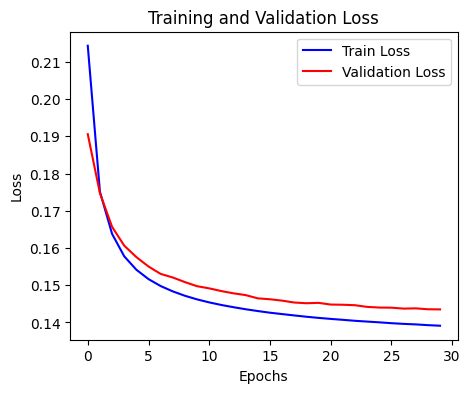

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating Images with VAE

We now demonstrate the generative properties of the VAE we just trained, by sampling from its latent space. Hence, we compute mean latent representations for each digit and pass them through the decoder to generate synthetic images,  in order to assess the VAE's ability to produce accurate representations of each digit.


In [ ]:
values = None
all_labels = []
with torch.no_grad():
  for imgs, labels in train_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))

values.shape, len(all_labels)

(torch.Size([60000, 4]), 60000)

In [ ]:
all_means = {}
all_labels = np.array(all_labels)
for i in range(10):
  inds = np.argwhere(all_labels == i)
  num_latents = values[inds].squeeze().numpy()
  mean = num_latents.mean(axis=0)
  all_means[i] = mean

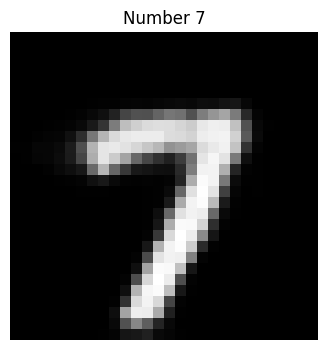

In [ ]:
number = 7
with torch.no_grad():
  pred = dec(torch.Tensor(all_means[number])[None, ...].to(device)).cpu()

img = transforms.ToPILImage()(pred.squeeze(0))

plt.figure(figsize=(4, 4))
plt.title(f'Number {number}')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
all_means

{0: array([2.1907573, 1.5016098, 2.451712 , 3.3809426], dtype=float32),
 1: array([-2.3081746,  1.1154157, -1.999238 , -1.0724154], dtype=float32),
 2: array([-1.0169742 , -2.185083  ,  0.34337926,  0.87197626], dtype=float32),
 3: array([-0.28075498, -0.2957586 ,  0.24778716, -0.14078017], dtype=float32),
 4: array([ 2.0113993 ,  4.175234  , -0.77646583, -0.31586742], dtype=float32),
 5: array([-0.15481356,  1.102118  , -0.01267089,  0.7718948 ], dtype=float32),
 6: array([-1.1662881 ,  2.5605462 ,  2.1982548 , -0.02672057], dtype=float32),
 7: array([ 2.674625 ,  0.3303709, -2.7116218, -1.4456091], dtype=float32),
 8: array([ 0.1841759 ,  0.35927436, -0.50138295,  0.24207519], dtype=float32),
 9: array([ 1.2926211,  2.074317 , -0.8303755, -0.8045303], dtype=float32)}

In [ ]:
ranges = [np.linspace(-2, 2, 5),
          np.linspace(-2, 3, 5),
          np.linspace(-2, 2, 5),
          np.linspace(-1, 3, 5)]
samples = np.array(list(itertools.product(*ranges)))

with torch.no_grad():
  predictions = dec(torch.Tensor(samples).to(device)).cpu()
predictions.size()

torch.Size([625, 1, 28, 28])

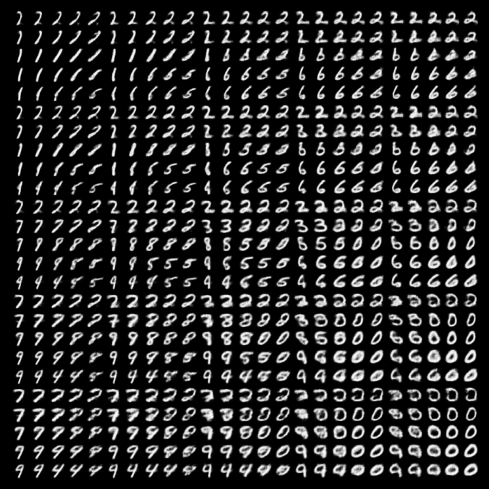

In [ ]:
n = int(np.sqrt(predictions.size(0)))
fig, ax = plt.subplots(n, n, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0}, facecolor='black')
ax_flat = ax.flatten()
for i in range(n**2):
    img = predictions[i, 0]
    ax = ax_flat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Improvements on the Latent Space
We are now going to polish the latent space by modifying the loss function. Before doing this, however, we are going to train the same model but using only a `z_dim = 2`, that is, we are going to reduce the dimensionality of the latent space from 4 to 2. This will result in less expressivity of the network, but will allow us to represent the points in the latent space and validate our later choices.

In [ ]:
z_dim = 2
enc = Encoder(z_dim=z_dim).to(device)
dec = Decoder(z_dim=z_dim).to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43170
Number of trainable parameters in Decoder: 43441


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

_, _ = training_loop(
            n_epochs = 40,
            optimizer_enc = optimizer_enc,
            optimizer_dec = optimizer_dec,
            enc = enc,
            dec = dec,
            loss_fn = nn.BCELoss(),
            train_loader = train_dl,
            val_loader = val_dl
            )

2024-04-10 20:18:43.380999 Epoch 1, Training Loss 0.3187635879715284, Validation Loss 0.21982133641839027
2024-04-10 20:20:15.685445 Epoch 10, Training Loss 0.17910064434011777, Validation Loss 0.18223149687051773
2024-04-10 20:21:55.536543 Epoch 20, Training Loss 0.1742223979284366, Validation Loss 0.17799560993909835
2024-04-10 20:23:35.186836 Epoch 30, Training Loss 0.17197487605114778, Validation Loss 0.17664790496230126
2024-04-10 20:25:16.785805 Epoch 40, Training Loss 0.17060156397521495, Validation Loss 0.174366118311882


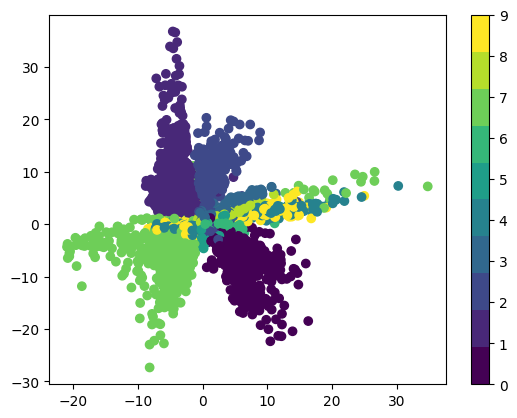

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap)
plt.colorbar(scatter)
plt.show()

In [ ]:
ranges = [np.linspace(-10, 10, 20),
          np.linspace(-10, 10, 20)]
samples = np.array(list(itertools.product(*ranges)))

with torch.no_grad():
  predictions = dec(torch.Tensor(samples).to(device)).cpu()
predictions.size()

torch.Size([400, 1, 28, 28])

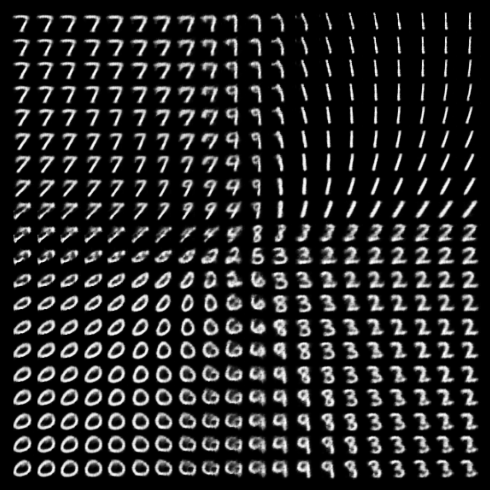

In [ ]:
n = int(np.sqrt(predictions.size(0)))
fig, ax = plt.subplots(n, n, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0}, facecolor='black')
ax_flat = ax.flatten()
for i in range(n**2):
    img = predictions[i, 0]
    ax = ax_flat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('reconstruction_loss.csv', index=False)


From the above plot, we can observe that the latent space has somewhat a structure, as the numbers are mostly grouped together in clusters. This, however, is not true for all numbers, more specifically the higher ones, whose points overlap each other. This means that when we sample from that region to generate an image, we are not sure to get a 8 or a 9.
Something else we can observe is that the latent space is not dense, but there are big gaps between the clusters. This means that when we sample in between two clusters, we don't get a distintictive picture of a number.
To summarize, we would like the latent space to be better structure with clear partitions for each digit and dense. In the following cells we are going to analyze how to achieve this.

## KL Divergence in Variational Autoencoder (VAE)

The Kullback-Leibler (KL) divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. In the context of VAEs, it quantifies the difference between the learned latent distribution and a predefined prior distribution, typically a standard Gaussian distribution.


The formula for the KL divergence between two normal distributions with mean $\mu$ and log variance $\log \sigma^2$ is given by:

$$ D_{KL}(N(\mu_1, \sigma_1^2) || N(\mu_2, \sigma_2^2)) = \frac{1}{2} \left( \frac{\sigma_1^2}{\sigma_2^2} + \frac{(\mu_2 - \mu_1)^2}{\sigma_2^2} - 1 + \log \left( \frac{\sigma_2^2}{\sigma_1^2} \right) \right) $$

This formula quantifies the difference between the means and variances of the two distributions.

### Effect on VAE Training:

- **Regularization:** Adding the KL divergence term to the loss function acts as a form of regularization. It encourages the VAE to learn a latent space that follows the desired prior distribution, typically a standard Gaussian distribution. This regularization helps prevent overfitting and encourages the VAE to generate more coherent and diverse samples.

- **Balancing Reconstruction and Regularization:** The overall loss function of a VAE combines the reconstruction loss (measuring the fidelity of reconstructed samples) and the KL divergence term. Balancing these two components is crucial during training. The reconstruction loss ensures that the generated samples resemble the input data, while the KL divergence term encourages a well-structured latent space.

By optimizing the combined loss function, the VAE learns to generate high-quality samples while also ensuring that the learned latent space has desirable properties, leading to improved generative performance.

Let's first only use the KL divergence as loss function, to understand its effect alone.



In [ ]:
def training_loop(n_epochs, optimizer_enc, optimizer_dec, enc, dec, train_loader, val_loader):
  k = 2
  std_normal_mu = torch.zeros(k).to(device)
  std_normal_var = torch.eye(k).to(device)
  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      latents = enc(imgs)
      mu = latents.mean(dim=0).to(device)
      var = torch.Tensor(np.cov(latents.cpu().detach().numpy(), rowvar=False)).to(device)

      kl_divergence_train =  0.5 * (torch.trace(torch.inverse(std_normal_var) @ var) +
                            (mu - std_normal_mu) @ torch.inverse(std_normal_var) @ (mu - std_normal_mu) -
                            k + torch.log(torch.det(std_normal_var) / torch.det(var)))


      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      kl_divergence_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += kl_divergence_train.item()

    for imgs, _ in val_loader:
      latents = enc(imgs.to(device))
      mu = latents.mean(dim=0).to(device)
      var = torch.Tensor(np.cov(latents.cpu().detach().numpy(), rowvar=False)).to(device)
      kl_divergence_val = 0.5 * (torch.trace(torch.inverse(std_normal_var) @ var) +
                          (mu - std_normal_mu) @ torch.inverse(std_normal_var) @ (mu - std_normal_mu) -
                           k + torch.log(torch.det(std_normal_var) / torch.det(var)))
      val_epoch_loss += kl_divergence_val.item()


    if epoch == 1 or epoch % 5 == 0:
      print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))


In [ ]:
z_dim = 2
enc = Encoder(z_dim=z_dim).to(device)
dec = Decoder(z_dim=z_dim).to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43170
Number of trainable parameters in Decoder: 43441


In [ ]:
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=0.00001)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=0.00001)

training_loop(
      n_epochs = 10,
      optimizer_enc = optimizer_enc,
      optimizer_dec = optimizer_dec,
      enc = enc,
      dec = dec,
      train_loader = train_dl,
      val_loader = val_dl
      )

2024-04-10 20:26:17.902091 Epoch 1, Training Loss 4.7850692192713415, Validation Loss 4.8537814950942995
2024-04-10 20:26:56.441888 Epoch 5, Training Loss 5.2782950019836425, Validation Loss 5.3269743156433105
2024-04-10 20:27:46.376687 Epoch 10, Training Loss 5.720399535497029, Validation Loss 5.761999402046204


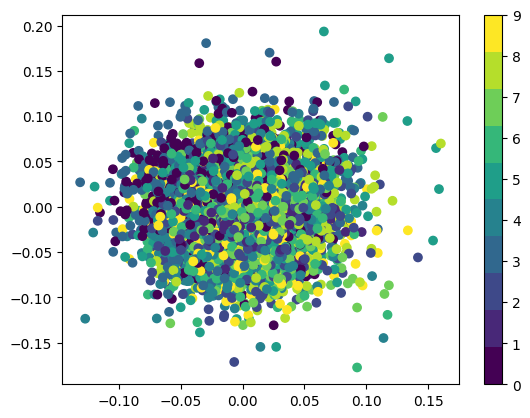

In [ ]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap)
plt.colorbar(scatter)
plt.show()

In [ ]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('KL_div_only.csv', index=False)

In [16]:
def training_loop(n_epochs, optimizer_enc, optimizer_dec, enc, dec, loss_fn, train_loader, val_loader, beta=3):
  train_loss = []
  val_loss = []

  k = 2
  std_normal_mu = torch.zeros(k).to(device)
  std_normal_var = torch.eye(k).to(device)

  for epoch  in range(1, n_epochs+1):
    train_epoch_loss = 0.0
    val_epoch_loss = 0.0

    for imgs, _ in train_loader:
      imgs = imgs.to(device)
      latents = enc(imgs)
      mu = latents.mean(dim=0).to(device)
      var = torch.Tensor(np.cov(latents.cpu().detach().numpy(), rowvar=False)).to(device)
      outputs = dec(latents).to(device)

      kl_divergence_train = 0.5 * (torch.trace(torch.inverse(std_normal_var) @ var) +
                            (mu - std_normal_mu) @ torch.inverse(std_normal_var) @ (mu - std_normal_mu) -
                              k + torch.log(torch.det(std_normal_var) / torch.det(var)))
      loss_train = loss_fn(outputs, imgs) + beta*kl_divergence_train

      optimizer_enc.zero_grad()
      optimizer_dec.zero_grad()

      loss_train.backward()
      optimizer_enc.step()
      optimizer_dec.step()

      train_epoch_loss += loss_train.item()

    for imgs, _ in val_loader:
      imgs = imgs.to(device)
      latents = enc(imgs)
      mu = latents.mean(dim=0).to(device)
      var = torch.Tensor(np.cov(latents.cpu().detach().numpy(), rowvar=False)).to(device)
      outputs = dec(latents).to(device)

      kl_divergence_val = 0.5 * (torch.trace(torch.inverse(std_normal_var) @ var) +
                     (mu - std_normal_mu) @ torch.inverse(std_normal_var) @ (mu - std_normal_mu) -
                     k + torch.log(torch.det(std_normal_var) / torch.det(var)))
      loss_val = loss_fn(outputs, imgs) + beta*kl_divergence_val
      val_epoch_loss += loss_val.item()


    if epoch == 1 or epoch % 5 == 0:
      print('{} Epoch {}, Training Loss {}, Validation Loss {}'.format(datetime.datetime.now(), epoch, train_epoch_loss / len(train_loader), val_epoch_loss / len(val_loader)))

    train_loss.append(train_epoch_loss / len(train_loader))
    val_loss.append(val_epoch_loss / len(val_loader))

  return train_loss, val_loss

In [24]:
z_dim = 2
enc = Encoder(z_dim=z_dim).to(device)
dec = Decoder(z_dim=z_dim).to(device)

num_trainable_params_enc = sum(p.numel() for p in enc.parameters() if p.requires_grad)
num_trainable_params_dec = sum(p.numel() for p in dec.parameters() if p.requires_grad)

print(f"Number of trainable parameters in Encoder: {num_trainable_params_enc}")
print(f"Number of trainable parameters in Decoder: {num_trainable_params_dec}")

Number of trainable parameters in Encoder: 43170
Number of trainable parameters in Decoder: 43441


In [25]:
optimizer_enc = torch.optim.Adam(enc.parameters(), lr=0.0001)
optimizer_dec = torch.optim.Adam(dec.parameters(), lr=0.0001)

train_loss, val_loss = training_loop(
          n_epochs = 20,
          optimizer_enc = optimizer_enc,
          optimizer_dec = optimizer_dec,
          enc = enc,
          dec = dec,
          loss_fn = nn.BCELoss(),
          train_loader = train_dl,
          val_loader = val_dl
          )

2024-04-15 20:23:01.797418 Epoch 1, Training Loss 16.31159533818563, Validation Loss 13.751984853744506
2024-04-15 20:23:48.790901 Epoch 5, Training Loss 10.068476077715555, Validation Loss 10.245392589569091
2024-04-15 20:24:48.185476 Epoch 10, Training Loss 9.426661562919616, Validation Loss 9.696717877388
2024-04-15 20:25:46.356405 Epoch 15, Training Loss 9.013267591794332, Validation Loss 9.180006437301635
2024-04-15 20:26:44.119613 Epoch 20, Training Loss 8.730342699686686, Validation Loss 8.901370220184326


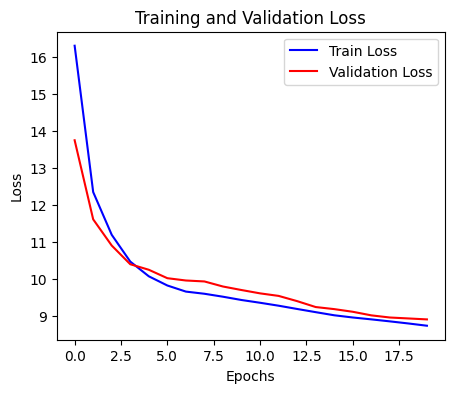

In [26]:
plt.figure(figsize=(5, 4))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

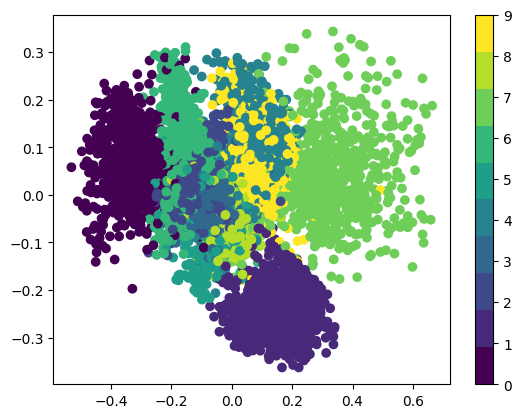

In [31]:
values = None
all_labels = []

with torch.no_grad():
  for imgs, labels in val_dl:
    imgs = imgs.to(device)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack((values, latents.cpu()))


cmap = plt.get_cmap('viridis', 10)
scatter = plt.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=cmap)
plt.colorbar(scatter)
plt.show()

In [31]:
# Save values for plotting later
df = pd.DataFrame({'Latent1': values[:, 0], 'Latent2': values[:, 1], 'Label': all_labels})
df.to_csv('reconstruction_KL_div.csv', index=False)

In [71]:
# Save trained model
torch.save(enc, 'enc.pth')
torch.save(dec, 'dec.pth')

In [53]:
ranges = [np.linspace(-0.4, 0.6, 15),
          np.linspace(-0.1, 0.3, 15)]
samples = np.array(list(itertools.product(*ranges)))
with torch.no_grad():
  predictions = dec(torch.Tensor(samples).to(device)).cpu()
predictions.size()

(225, 2)


torch.Size([225, 1, 28, 28])

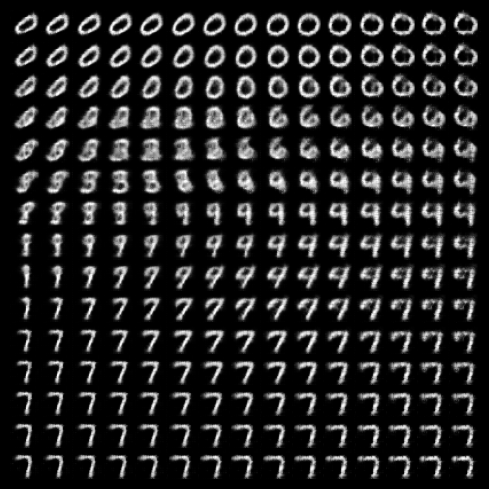

In [39]:
n = int(np.sqrt(predictions.size(0)))
fig, ax = plt.subplots(n, n, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0}, facecolor='black')
ax_flat = ax.flatten()
for i in range(n**2):
    img = predictions[i, 0]
    ax = ax_flat[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Interactive plot

In [2]:
import mplcursors

In [4]:
# Import the CSV file using pandas
df = pd.read_csv('reconstruction_KL_div.csv')
values = df.iloc[:, :2].values
all_labels = df.iloc[:, 2].values

In [5]:
enc = torch.load('enc.pth', map_location=torch.device('cpu'))
dec = torch.load('dec.pth', map_location=torch.device('cpu'))

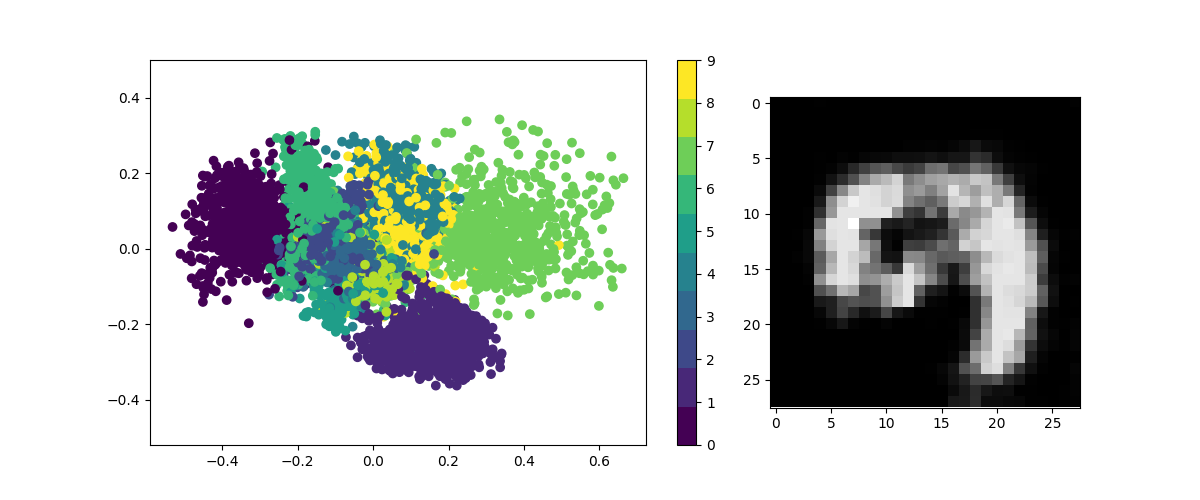

In [42]:
%matplotlib widget

def decode_image(sample):
    with torch.no_grad():
      pred = dec(torch.Tensor(sample).unsqueeze(0).to(device)).squeeze(0).cpu()

    return pred.permute(1, 2, 0)

def mouse_event(event):
    if event.inaxes:
        x, y = event.xdata, event.ydata
        decoded_image = decode_image([x, y])  # Feed x, y coordinates into decode_image
        ax2.imshow(decoded_image, cmap='gray')
        plt.draw()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})
ax1, ax2 = axs

scatter = ax1.scatter(values[:, 0], values[:, 1], c=all_labels, cmap=plt.get_cmap('viridis', 10))
plt.colorbar(scatter)
ax1.axis('equal')

decoded_image = decode_image(values[0])
image_display = ax2.imshow(decoded_image, cmap='gray')

fig.canvas.mpl_connect('motion_notify_event', mouse_event)

plt.subplots_adjust(wspace=0)
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')